In [4]:
from functions import * # importing our own functions defined in functions.py

import matplotlib.pyplot as plt
plt.style.use(['classic'])
plt.rcParams['figure.facecolor'] = 'white'

For our evaluation, we are using the Adversarial Robustness Toolbox found [here](https://adversarial-robustness-toolbox.readthedocs.io/en/latest/).

# Importing MNIST

In [5]:
from art.utils import load_dataset

(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset(str("cifar10"))
print(min_, max_)

0.0 1.0


# Training Classifiers

## Generalized Gamma

In [6]:
@tf.custom_gradient
def gamma_activation(x):
    def grad(dy):
        return gamma_derivative(x) * dy

    result = generalized_gamma(x)
    return result, grad

In [7]:
model = define_model(gamma_activation)
classifier = train_model(model, x_train, y_train, x_test, y_test, eps=65)

...created classifier
Before training time (EST):  2023-05-22 15:07:23.237271-05:00
...finished training
Time after training finished:  2023-05-22 15:41:26.984035-05:00
Test accuracy: 52.06%



In [8]:
eval_x_test, eval_y_test = get_successful_test(classifier, x_test, y_test)

Original test accuracy: 52.06%
(1000, 32, 32, 3)
(1000, 10)
Test set of correctly predicted (benign): 100.00%


## ReLU

In [9]:
model_relu = define_model(tf.nn.relu)
classifier_relu = train_model(model_relu, x_train, y_train, x_test, y_test, eps=50)


...created classifier
Before training time (EST):  2023-05-22 15:41:32.488950-05:00
...finished training
Time after training finished:  2023-05-22 15:54:27.206773-05:00
Test accuracy: 58.32%



In [10]:
eval_x_test_relu, eval_y_test_relu = get_successful_test(classifier_relu, x_test, y_test)

Original test accuracy: 58.32%
(1000, 32, 32, 3)
(1000, 10)
Test set of correctly predicted (benign): 100.00%


## Tanh

In [11]:
model_tanh = define_model(tf.nn.tanh)
classifier_tanh = train_model(model_tanh, x_train, y_train, x_test, y_test, eps=50)


...created classifier
Before training time (EST):  2023-05-22 15:54:29.930440-05:00
...finished training
Time after training finished:  2023-05-22 16:07:26.893573-05:00
Test accuracy: 60.23%



In [12]:
eval_x_test_tanh, eval_y_test_tanh = get_successful_test(classifier_tanh, x_test, y_test)

Original test accuracy: 60.23%
(1000, 32, 32, 3)
(1000, 10)
Test set of correctly predicted (benign): 100.00%


## Swish

In [13]:
model_swish = define_model(tf.keras.activations.swish)
classifier_swish = train_model(model_swish, x_train, y_train, x_test, y_test, eps=50)


...created classifier
Before training time (EST):  2023-05-22 16:07:29.618369-05:00
...finished training
Time after training finished:  2023-05-22 16:23:12.106146-05:00
Test accuracy: 55.22%



In [14]:
eval_x_test_swish, eval_y_test_swish = get_successful_test(classifier_swish, x_test, y_test)

Original test accuracy: 55.22%
(1000, 32, 32, 3)
(1000, 10)
Test set of correctly predicted (benign): 100.00%


# Attacking Models

## Fast Gradient Sign

In [15]:
fgsm_results_gengamma = []
fgsm_results_relu = []
fgsm_results_tanh = []
fgsm_results_swish = []

eps = np.linspace(0, 0.2, 20)
for epsilon in eps:
    fgsm_results_gengamma += [fgsm_attack(classifier, eval_x_test, eval_y_test, eps=epsilon)]
    fgsm_results_relu += [fgsm_attack(classifier_relu, eval_x_test_relu, eval_y_test_relu, eps=epsilon)]
    fgsm_results_tanh += [fgsm_attack(classifier_tanh, eval_x_test_tanh, eval_y_test_tanh, eps=epsilon)]
    fgsm_results_swish += [fgsm_attack(classifier_swish, eval_x_test_swish, eval_y_test_swish, eps=epsilon)]

    print("eps "+str(epsilon)+" done")

eps 0.0 done
eps 0.010526315789473684 done
eps 0.021052631578947368 done
eps 0.031578947368421054 done
eps 0.042105263157894736 done
eps 0.05263157894736842 done
eps 0.06315789473684211 done
eps 0.07368421052631578 done
eps 0.08421052631578947 done
eps 0.09473684210526316 done
eps 0.10526315789473684 done
eps 0.11578947368421053 done
eps 0.12631578947368421 done
eps 0.1368421052631579 done
eps 0.14736842105263157 done
eps 0.15789473684210525 done
eps 0.16842105263157894 done
eps 0.17894736842105263 done
eps 0.18947368421052632 done
eps 0.2 done


In [16]:
## comparing with SPLASH and tent paper
print(fgsm_attack(classifier, eval_x_test, eval_y_test, eps=0.06))
print(fgsm_attack(classifier_relu, eval_x_test_relu, eval_y_test_relu, eps=0.06))
print(fgsm_attack(classifier_swish, eval_x_test_swish, eval_y_test_swish, eps=0.06))

3.8
1.5
2.1


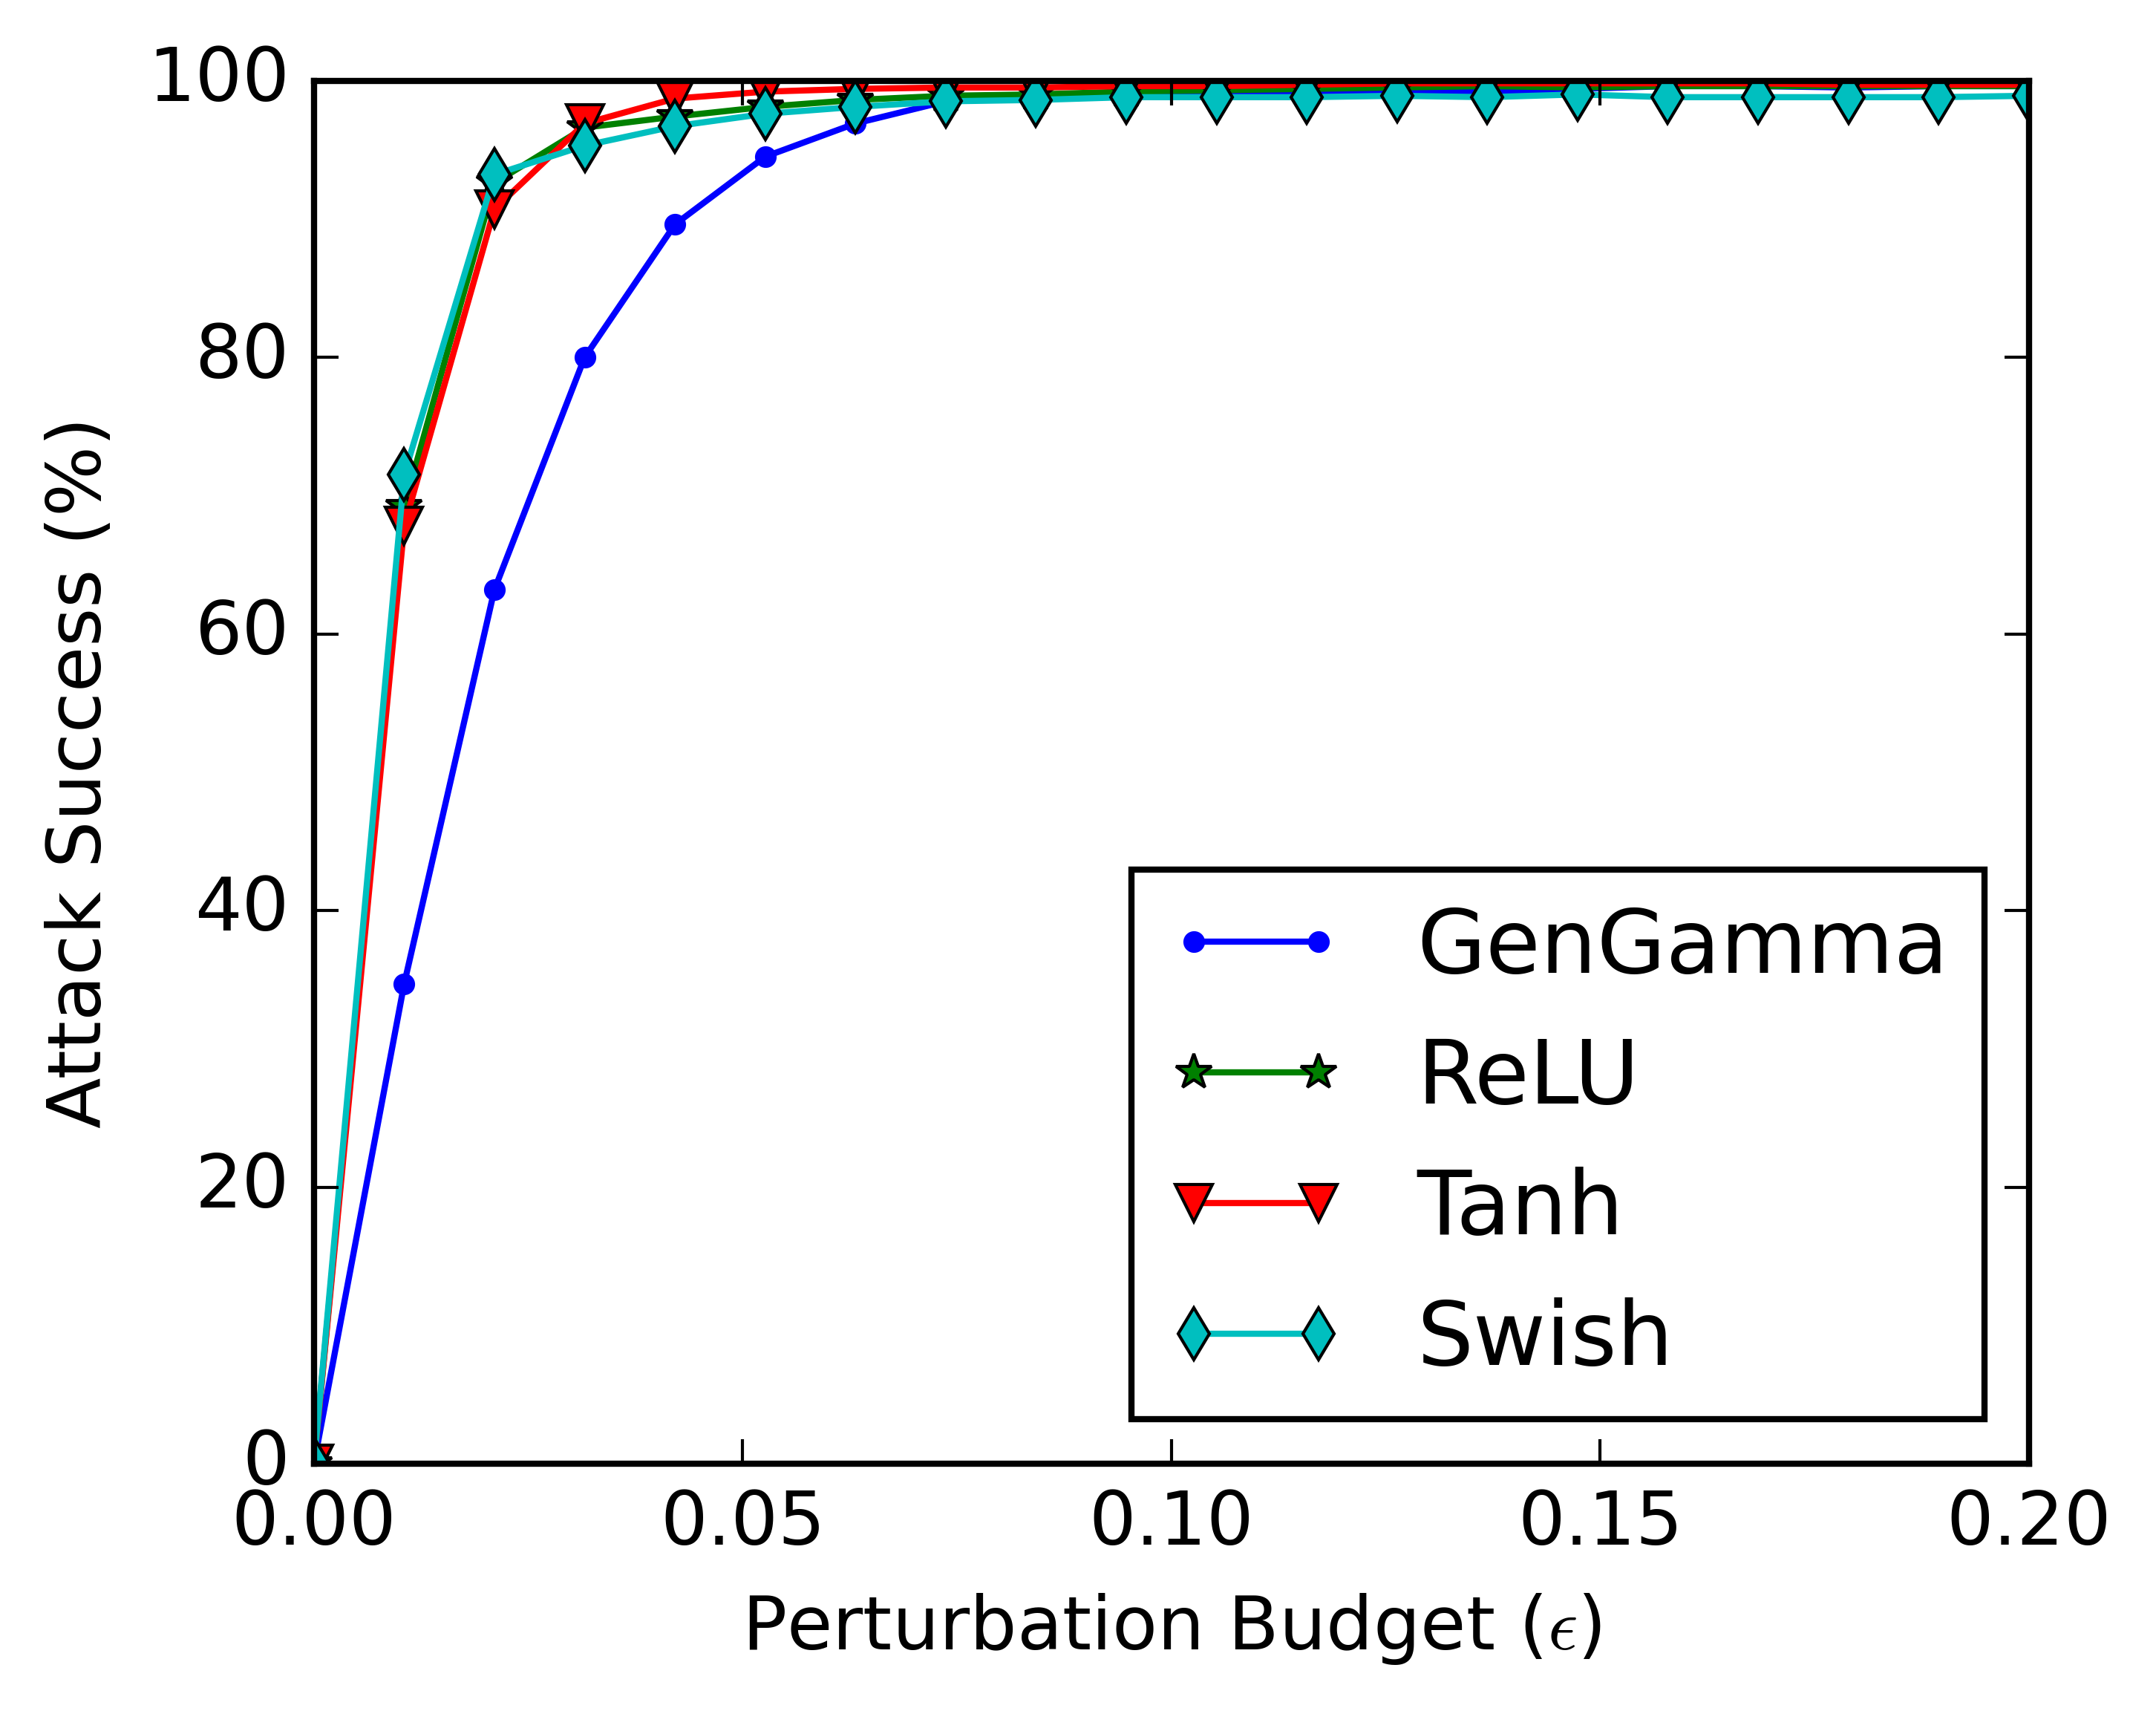

In [17]:
plt.figure(figsize=(5,4), dpi=600)
plt.plot(eps, attack_success(fgsm_results_gengamma), label='GenGamma', marker='.')
plt.plot(eps, attack_success(fgsm_results_relu), label='ReLU', marker='*')
plt.plot(eps, attack_success(fgsm_results_tanh), label='Tanh', marker='v')
plt.plot(eps, attack_success(fgsm_results_swish), label='Swish', marker='d')

plt.legend(loc='lower right')
axes = plt.gca()
axes.set_ylim([0, 100])
plt.xlabel('Perturbation Budget ($\epsilon$)')
plt.ylabel('Attack Success (%)')
plt.tight_layout()
plt.savefig('images/fgsm_results_lenet_cifar.png', dpi=600)
plt.show()

## PGD

In [18]:
pgd_results_gengamma = []
pgd_results_relu = []
pgd_results_tanh = []
pgd_results_swish = []

eps = np.linspace(0, 0.15, 15)
for epsilon in eps:
    pgd_results_gengamma += [pgd_attack(classifier, eval_x_test, eval_y_test, eps=epsilon)]
    pgd_results_relu += [pgd_attack(classifier_relu, eval_x_test_relu, eval_y_test_relu, eps=epsilon)]
    pgd_results_tanh += [pgd_attack(classifier_tanh, eval_x_test_tanh, eval_y_test_tanh, eps=epsilon)]
    pgd_results_swish += [pgd_attack(classifier_swish, eval_x_test_swish, eval_y_test_swish, eps=epsilon)]

    print("eps "+str(epsilon)+" done")

eps 0.0 done
eps 0.010714285714285714 done
eps 0.02142857142857143 done
eps 0.03214285714285714 done
eps 0.04285714285714286 done
eps 0.053571428571428575 done
eps 0.06428571428571428 done
eps 0.075 done
eps 0.08571428571428572 done
eps 0.09642857142857143 done
eps 0.10714285714285715 done
eps 0.11785714285714285 done
eps 0.12857142857142856 done
eps 0.1392857142857143 done
eps 0.15 done


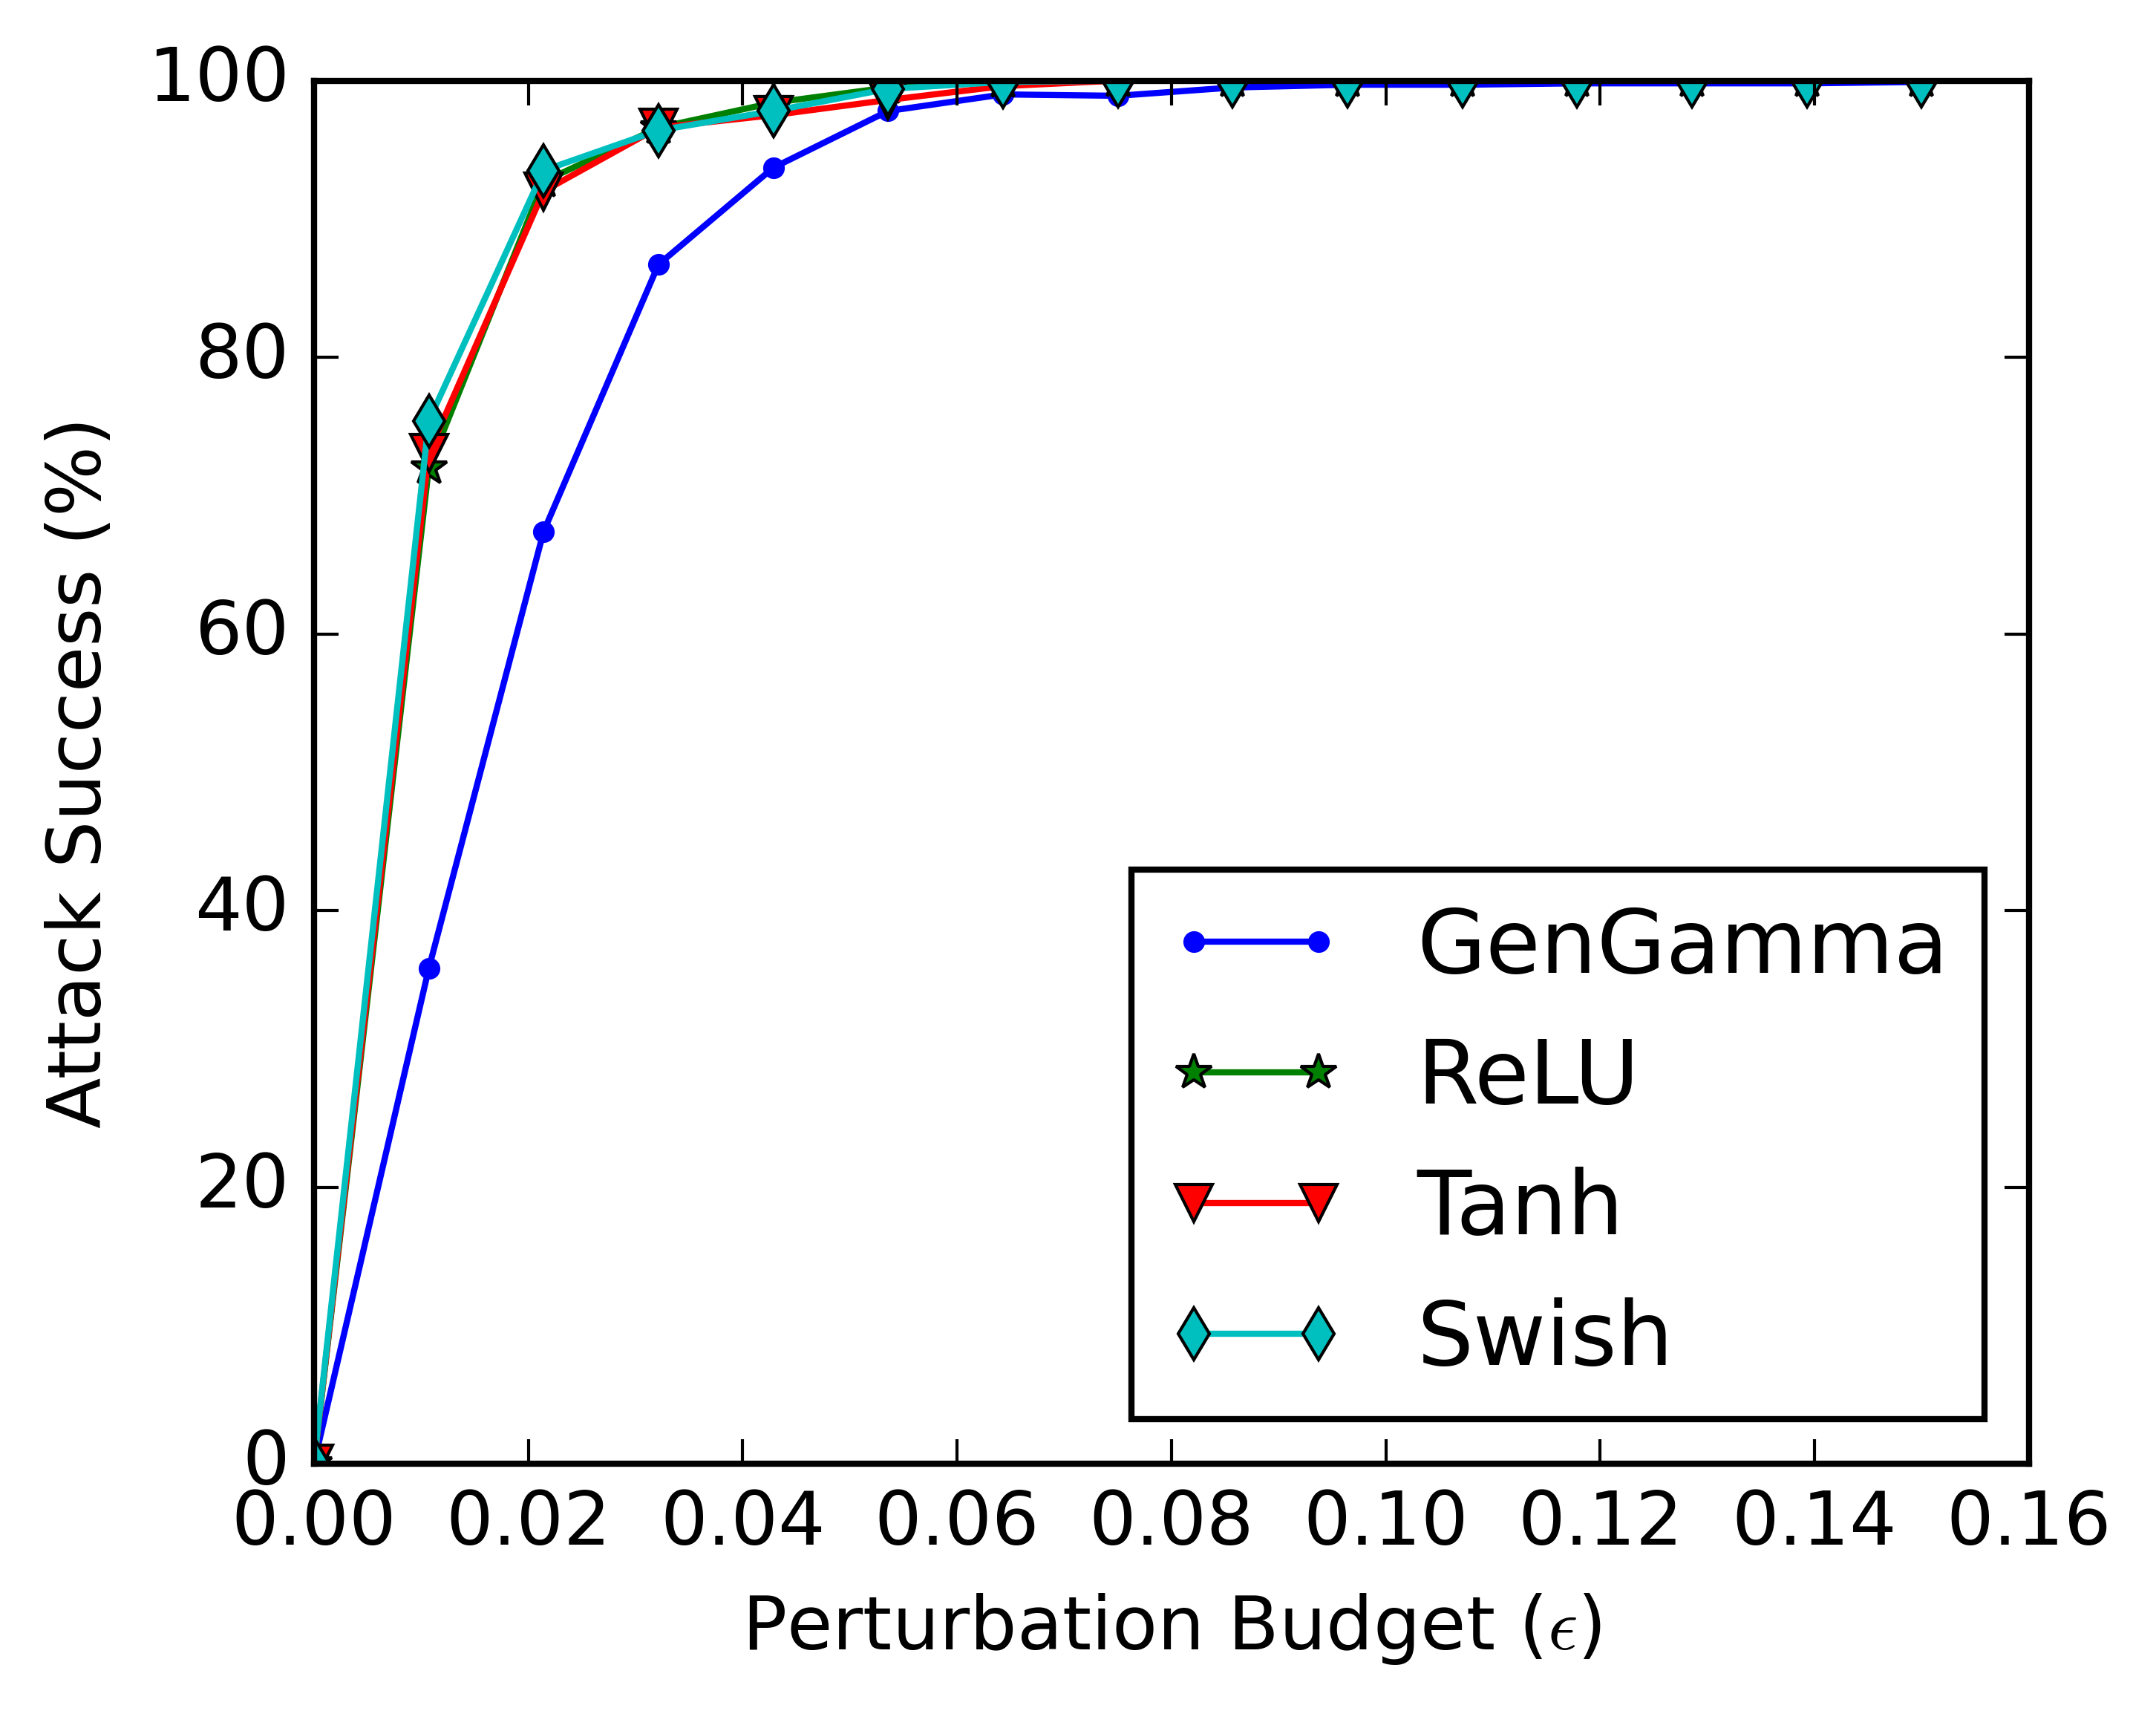

In [19]:
plt.figure(figsize=(5,4), dpi=600)

plt.plot(eps, attack_success(pgd_results_gengamma), label='GenGamma', marker='.')
plt.plot(eps, attack_success(pgd_results_relu), label='ReLU', marker='*')
plt.plot(eps, attack_success(pgd_results_tanh), label='Tanh', marker='v')
plt.plot(eps, attack_success(pgd_results_swish), label='Swish', marker='d')

plt.legend(loc='lower right')
axes = plt.gca()
axes.set_ylim([0, 100])
plt.xlabel('Perturbation Budget ($\epsilon$)')
plt.ylabel('Attack Success (%)')
plt.tight_layout()
plt.savefig('images/pgd_results_lenet_cifar.png', dpi=600)
plt.show()

## Carlini & Wagner L2/inf

In [38]:
## want a smaller eval size due to computational constraints
def get_successful_test(classifier, x_test, y_test):
    preds = np.argmax(classifier.predict(x_test), axis=1)
    acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
    print("Original test accuracy: %.2f%%" % (acc * 100))
    
    preds = np.argmax(classifier.predict(x_test), axis=1)
    correct = np.nonzero(preds == np.argmax(y_test, axis=1))

    eval_x_test = x_test[correct]
    eval_y_test = y_test[correct]

    eval_x_test_final = eval_x_test[:100]
    print(eval_x_test_final.shape)
    eval_y_test_final = eval_y_test[:100]
    print(eval_y_test_final.shape)
    
    preds = np.argmax(classifier.predict(eval_x_test_final), axis=1)
    acc = np.sum(preds == np.argmax(eval_y_test_final, axis=1)) / eval_y_test_final.shape[0]
    print("Test set of correctly predicted (benign): %.2f%%" % (acc * 100))
    
    return eval_x_test_final, eval_y_test_final

eval_x_test_gengamma, eval_y_test_gengamma = get_successful_test(classifier, x_test, y_test)
eval_x_test_relu, eval_y_test_relu = get_successful_test(classifier_relu, x_test, y_test)
eval_x_test_tanh, eval_y_test_tanh = get_successful_test(classifier_tanh, x_test, y_test)
eval_x_test_swish, eval_y_test_swish = get_successful_test(classifier_swish, x_test, y_test)

print(eval_x_test_gengamma.shape)

Original test accuracy: 47.63%
(100, 32, 32, 3)
(100, 10)
Test set of correctly predicted (benign): 100.00%
Original test accuracy: 58.26%
(100, 32, 32, 3)
(100, 10)
Test set of correctly predicted (benign): 100.00%
Original test accuracy: 61.07%
(100, 32, 32, 3)
(100, 10)
Test set of correctly predicted (benign): 100.00%
Original test accuracy: 56.14%
(100, 32, 32, 3)
(100, 10)
Test set of correctly predicted (benign): 100.00%
(100, 32, 32, 3)


In [39]:
cw_results_gengamma = []
cw_results_relu = []
cw_results_tanh = []
cw_results_swish = []

eps = np.linspace(0, 0.4, 4)
for epsilon in eps:
    cw_results_gengamma += [cwl2_attack(classifier, eval_x_test_gengamma, eval_y_test_gengamma, eps=epsilon)]
    cw_results_relu += [cwl2_attack(classifier_relu, eval_x_test_relu, eval_y_test_relu, eps=epsilon)]
    cw_results_tanh += [cwl2_attack(classifier_tanh, eval_x_test_tanh, eval_y_test_tanh, eps=epsilon)]
    cw_results_swish += [cwl2_attack(classifier_swish, eval_x_test_swish, eval_y_test_swish, eps=epsilon)]

    print("eps "+str(epsilon)+" done")

...creating adversarial examples


C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy on adversarial sample: 12.00%
[12.0]
[]
...creating adversarial examples


C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy on adversarial sample: 23.00%
[23.0]
...creating adversarial examples


C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy on adversarial sample: 3.00%
[3.0]
...creating adversarial examples


C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy on adversarial sample: 20.00%
[20.0]

eps 0.0 done

...creating adversarial examples


C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy on adversarial sample: 24.00%
[12.0, 24.0]
[]
...creating adversarial examples


C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy on adversarial sample: 23.00%
[23.0, 23.0]
...creating adversarial examples


C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy on adversarial sample: 0.00%
[3.0, 0.0]
...creating adversarial examples


C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy on adversarial sample: 20.00%
[20.0, 20.0]

eps 0.13333333333333333 done

...creating adversarial examples


C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy on adversarial sample: 36.00%
[12.0, 24.0, 36.0]
[]
...creating adversarial examples


C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy on adversarial sample: 23.00%
[23.0, 23.0, 23.0]
...creating adversarial examples


C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy on adversarial sample: 0.00%
[3.0, 0.0, 0.0]
...creating adversarial examples


C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy on adversarial sample: 20.00%
[20.0, 20.0, 20.0]

eps 0.26666666666666666 done

...creating adversarial examples


C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy on adversarial sample: 51.00%
[12.0, 24.0, 36.0, 51.0]
[]
...creating adversarial examples


C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy on adversarial sample: 23.00%
[23.0, 23.0, 23.0, 23.0]
...creating adversarial examples


C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy on adversarial sample: 0.00%
[3.0, 0.0, 0.0, 0.0]
...creating adversarial examples


C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy on adversarial sample: 20.00%
[20.0, 20.0, 20.0, 20.0]

eps 0.4 done



In [41]:
print(cw_results_gengamma)
print(cw_results_relu)
print(cw_results_tanh)
print(cw_results_swish)

[12.0, 24.0, 36.0, 51.0]
[23.0, 23.0, 23.0, 23.0]
[3.0, 0.0, 0.0, 0.0]
[20.0, 20.0, 20.0, 20.0]
